In [1]:
# imports
import keras_tuner as kt
import numpy as np
from PIL import Image
import keras
from keras import layers
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
import zipfile
import os
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from keras.preprocessing.image import load_img, img_to_array,  array_to_img
from keras.models import Sequential, Model, load_model
from keras.layers import Convolution1D, Dense, Dropout, Activation, Convolution2D, MaxPooling2D, Flatten, Input, BatchNormalization
from tensorflow.keras.layers import concatenate, Input, Dense
from keras.optimizers import SGD, RMSprop, Adam
from keras.callbacks import ModelCheckpoint
from tensorflow import keras
from tensorflow.keras import layers
from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters

# Part 1: Data Preparation

## Load Data

First, we load the tabular datasets using Pandas. We have two zip files provided, 'train.zip' and 'test.zip'. They contain 'train.csv' and 'test.csv', respectively.

In [38]:
# First, we load the training data, taking care to load the image corresponding to each specific row
# Note: the test.csv is unlabelled so we will NOT be using it for evaluation. Instead, we will split train.csv

# load tabular data

train = pd.read_csv('train.csv.zip') # target = 'species'
test = pd.read_csv('test.csv.zip')

Next, we load the images. The images in 'images.zip' are unzipped into a folder titled 'images'. Each image file is named according to its corresponding ID in the tabular dataset. Therefore, we will iterate over the 'id' column in train dataset, to fetch each image in turn.

We will also preprocess the images. Each image is resized into dimensions (180, 180, 1). In addition, the images are appended and rescaled in the 'images_data' Numpy array.

Let us also display the first 25 images, to visualize what the data looks like.

In [3]:
# load images

train_IDs = train.id # id column to match tabular record with its image
images_data = [] # PIL images, turned Numpy array
image_size = (180, 180) #for image resizing

for idx in train_IDs:
    image_path = os.path.join('images', str(idx)+ '.jpg')
    # img = Image.open(image_path)
    img = load_img(image_path, color_mode = "grayscale")
    img = img.resize(image_size) #resizing
    images_data.append(img)


# Displaying the first 25 images
for i in range(25):
	plt.subplot(5, 5, i+1)
	plt.imshow(images_data[i], cmap=plt.get_cmap('gray'))
plt.show()


# PIL Images array to Numpy array
images_data = np.asarray(images_data)
images_data = images_data.astype('float32')
images_data /= 255
# print(images_data[0])
# print(images_data.shape) #(990, 180, 180) 990 images, 180 height, 180 width
# array = tf.keras.utils.img_to_array(images_data[10])
# print(array.shape) #(180, 180, 1)

## Data Visualization

Results: 
- Both train and test contain the 'id' column, but only train is labelled with 'species'. Therefore, we must split the train data into train and validation. test will be predicted by the model.
- There are 99 leaf species classifications.
- There are 3 features, and 64 sub-features. These features can be grouped together so we can carry out 1D Convolution.
- Each species has around 10 records in the train data. This makes the shape of train data(990, 3, 64), excluding 'id' and 'species'.
- There are no duplicates or nulls, which means we can encode and standardize straight-away.

In [4]:
train.head()
# test.head()

id                species   margin1   margin2   margin3   margin4  \
0   1            Acer_Opalus  0.007812  0.023438  0.023438  0.003906   
1   2  Pterocarya_Stenoptera  0.005859  0.000000  0.031250  0.015625   
2   3   Quercus_Hartwissiana  0.005859  0.009766  0.019531  0.007812   
3   5        Tilia_Tomentosa  0.000000  0.003906  0.023438  0.005859   
4   6     Quercus_Variabilis  0.005859  0.003906  0.048828  0.009766   

    margin5   margin6   margin7  margin8  ...  texture55  texture56  \
0  0.011719  0.009766  0.027344      0.0  ...   0.007812   0.000000   
1  0.025391  0.001953  0.019531      0.0  ...   0.000977   0.000000   
2  0.003906  0.005859  0.068359      0.0  ...   0.154300   0.000000   
3  0.021484  0.019531  0.023438      0.0  ...   0.000000   0.000977   
4  0.013672  0.015625  0.005859      0.0  ...   0.096680   0.000000   

   texture57  texture58  texture59  texture60  texture61  texture62  \
0   0.002930   0.002930   0.035156        0.0        0.0   0.004883   
1   0.000000   0.000977   0.023438        0.0        0.0   0.000977   
2   0.005859   0.000977   0.007812        0.0        0.0   0.000000   
3   0.000000   0.000000   0.020508        0.0        0.0   0.017578   
4   0.021484   0.000000   0.000000        0.0        0.0   0.000000   

   texture63  texture64  
0   0.000000   0.025391  
1   0.039062   0.022461  
2   0.020508   0.002930  
3   0.000000   0.047852  
4   0.000000   0.031250  

[5 rows x 194 columns]

In [5]:
# describe data

# count, mean, std, min, Q1, Q2, Q3, max
# train.describe()
train.groupby("species").describe() # notice how each species has 10 records. notice also there are 99 species
# res = set(train['species'])

# test.describe()

id                                             \
                             count    mean         std    min     25%     50%   
species                                                                         
Acer_Capillipes               10.0   875.5  520.993335  201.0  515.75   800.0   
Acer_Circinatum               10.0   597.6  484.619026  160.0  183.25   382.0   
Acer_Mono                     10.0   861.3  492.808741  216.0  491.50   849.5   
Acer_Opalus                   10.0  1005.4  488.280475    1.0  930.00  1142.0   
Acer_Palmatum                 10.0   776.7  555.473782   27.0  233.25  1000.5   
...                            ...     ...         ...    ...     ...     ...   
Tilia_Tomentosa               10.0   755.5  561.617950    5.0  273.00   795.5   
Ulmus_Bergmanniana            10.0   998.6  347.943227  436.0  765.25   995.0   
Viburnum_Tinus                10.0   858.1  311.974518  291.0  700.00   853.5   
Viburnum_x_Rhytidophylloides  10.0  1111.4  479.347983  152.0  802.25  1305.5   
Zelkova_Serrata               10.0   905.1  483.643222   17.0  580.75  1064.5   

                                              margin1            ...  \
                                  75%     max   count      mean  ...   
species                                                          ...   
Acer_Capillipes               1331.75  1562.0    10.0  0.001562  ...   
Acer_Circinatum                990.50  1506.0    10.0  0.000195  ...   
Acer_Mono                     1257.75  1556.0    10.0  0.021875  ...   
Acer_Opalus                   1307.50  1504.0    10.0  0.014453  ...   
Acer_Palmatum                 1087.25  1551.0    10.0  0.000195  ...   
...                               ...     ...     ...       ...  ...   
Tilia_Tomentosa               1240.50  1544.0    10.0  0.003515  ...   
Ulmus_Bergmanniana            1290.50  1448.0    10.0  0.001172  ...   
Viburnum_Tinus                1140.25  1240.0    10.0  0.035547  ...   
Viburnum_x_Rhytidophylloides  1438.00  1570.0    10.0  0.033399  ...   
Zelkova_Serrata               1248.25  1443.0    10.0  0.014258  ...   

                             texture63           texture64            \
                                   75%       max     count      mean   
species                                                                
Acer_Capillipes               0.029053  0.036133      10.0  0.007813   
Acer_Circinatum               0.000000  0.000000      10.0  0.015137   
Acer_Mono                     0.000000  0.000977      10.0  0.010351   
Acer_Opalus                   0.002442  0.014648      10.0  0.027344   
Acer_Palmatum                 0.000000  0.000000      10.0  0.016699   
...                                ...       ...       ...       ...   
Tilia_Tomentosa               0.000000  0.000000      10.0  0.028027   
Ulmus_Bergmanniana            0.023438  0.029297      10.0  0.000000   
Viburnum_Tinus                0.040772  0.046875      10.0  0.029395   
Viburnum_x_Rhytidophylloides  0.020752  0.036133      10.0  0.000000   
Zelkova_Serrata               0.007569  0.026367      10.0  0.018750   

                                                                      \
                                   std       min       25%       50%   
species                                                                
Acer_Capillipes               0.010991  0.000000  0.000000  0.000977   
Acer_Circinatum               0.010867  0.000977  0.007324  0.014160   
Acer_Mono                     0.008042  0.000977  0.005615  0.008301   
Acer_Opalus                   0.009524  0.011719  0.022705  0.026368   
Acer_Palmatum                 0.010421  0.008789  0.010010  0.010742   
...                                ...       ...       ...       ...   
Tilia_Tomentosa               0.014257  0.008789  0.013916  0.031739   
Ulmus_Bergmanniana            0.000000  0.000000  0.000000  0.000000   
Viburnum_Tinus                0.016525  0.004883  0.014160  0.035157   
Viburnum_x_Rhyt

In [6]:
train.info()
# train.shape # (990, 194)
# test.info()
# test.shape #(594, 193)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 990 entries, 0 to 989
Columns: 194 entries, id to texture64
dtypes: float64(192), int64(1), object(1)
memory usage: 1.5+ MB


In [7]:
print(train.dtypes) # during encoding, encode 'object' dtype field. the other fields are float64

id             int64
species       object
margin1      float64
margin2      float64
margin3      float64
              ...   
texture60    float64
texture61    float64
texture62    float64
texture63    float64
texture64    float64
Length: 194, dtype: object


In [8]:
# train.columns 
# test.columns
print(train.iloc[0]) # columns: 'id', 'species', 'margin1', 'margin2',... 'margin64', 64-sized vector also for 'shape' and 'texture'  
print(test.iloc[0]) # does not contain 'species' target column

id                     1
species      Acer_Opalus
margin1         0.007812
margin2         0.023438
margin3         0.023438
                ...     
texture60            0.0
texture61            0.0
texture62       0.004883
texture63            0.0
texture64       0.025391
Name: 0, Length: 194, dtype: object
id           4.000000
margin1      0.019531
margin2      0.009766
margin3      0.078125
margin4      0.011719
               ...   
texture60    0.000000
texture61    0.000000
texture62    0.000000
texture63    0.003906
texture64    0.053711
Name: 0, Length: 193, dtype: float64


In [9]:
# data cleaning
# drop duplicates and null
# (no duplicates or nulls)
for var in train.isnull().sum():
    if var != 0: print(var)
for var in test.isnull().sum():
    if var != 0: print(var)

# train.isnull().sum()
# test.isnull().sum()
# print(train.shape)
# print(train.drop_duplicates(inplace=False).shape)
# print(train.dropna(inplace=False).shape) #no duplicates or nulls

# print(test.shape)
# print(test.drop_duplicates(inplace=False).shape)
# print(test.dropna(inplace=False).shape)
#no duplicates or nulls


In [10]:
# Correlation Analysis

train_corr_copy = train.copy()

# Use LabelEncoder for encoding the 'Target' column
le = LabelEncoder()
train_corr_copy['species'] = le.fit_transform(train_corr_copy['species'])

# Extract numeric columns only
numeric_columns = train_corr_copy.select_dtypes(include=['number'])

# Calculate correlation matrix
correlation_matrix = train_corr_copy.corr()

# Create a mask for the upper triangle of the heatmap
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(20, 20))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', mask=mask, vmin=-1, vmax=1)

# Show the plot
plt.show()

d:\My Applications\my_python_venvs\deep\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


images\1.jpg
images\10.jpg
images\100.jpg
images\1000.jpg
images\1001.jpg


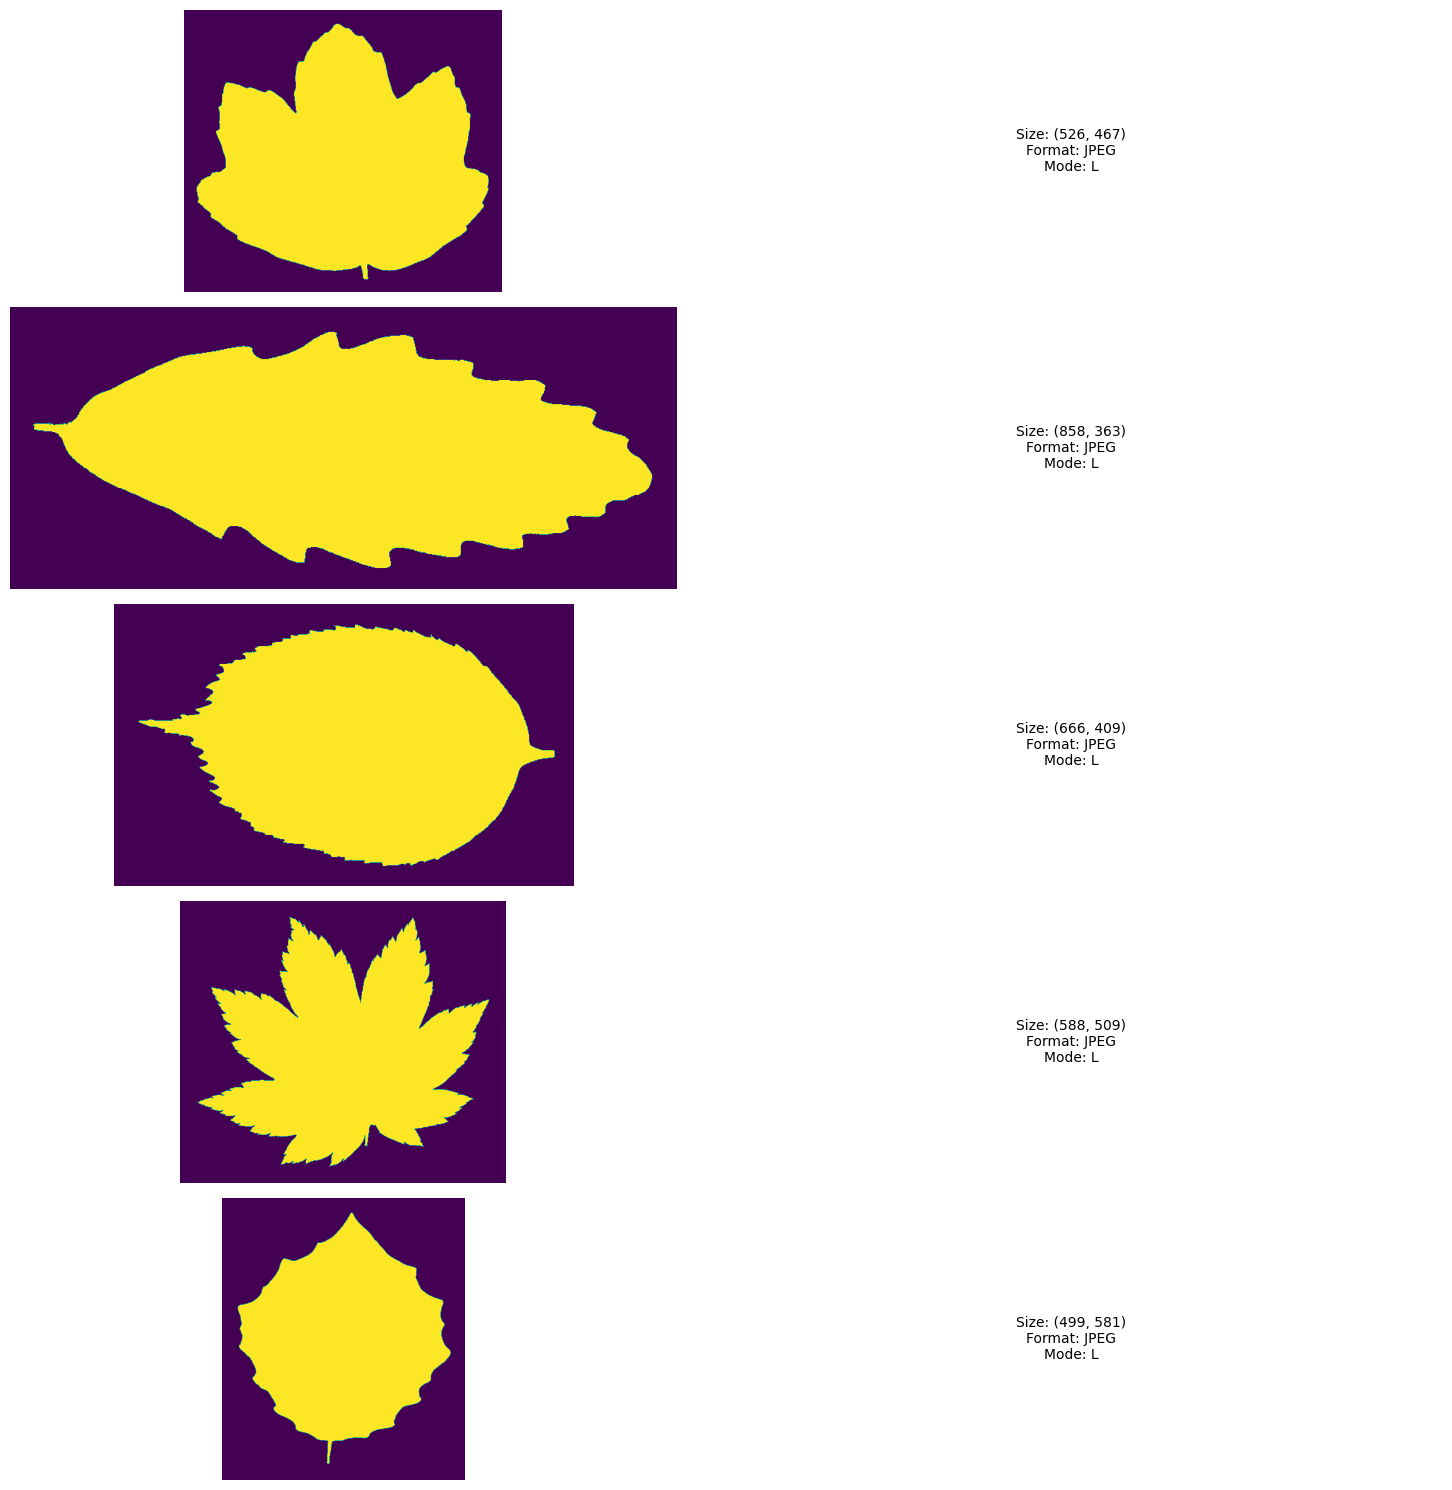

In [11]:
# EXTRA images visualization

# Display a few images from the folder (before processing)
num_images_to_display = 5
fig, axes = plt.subplots(num_images_to_display, 2, figsize=(15, 3 * num_images_to_display))
image_files = [f for f in os.listdir('images') if f.endswith('.jpg')]



for i in range(num_images_to_display):
    img_path = os.path.join('images', image_files[i])
    img = mpimg.imread(img_path)   
    print(img_path)


    # summarize image info
    #results: mode = 'L' i.e. grayscale. different sizes. jpeg
    pil_image = Image.open(img_path)
    size = pil_image.size
    format = pil_image.format
    mode = pil_image.mode

    #plot
    axes[i, 0].imshow(img)
    axes[i, 0].axis('off')  # Turn off axis labels

    
    axes[i, 1].text(0.5, 0.5, f"Size: {size}\nFormat: {format}\nMode: {mode}", 
                   fontsize=10, ha='center', va='center')
    axes[i, 1].axis('off')  # Turn off axis labels
    
plt.tight_layout()
plt.show()

## Preprocessing Data

In this step, we will preprocess only the tabular data, then stratify shuffle the images and tabular data. The result will be a train and validation set of images and tabular data (kept separate) and train and validation y label.

The tabular data will be fitted to LabelEncoder() and StandardScaler(), then reshaped to represent sub-features more clearly.

In [12]:
n_features = 64 # feature vector size
n_classes = 99 # species aka output



#StratifiedShuffleSplit params
random_state = 42
train_size = 0.8
n_splits = 1

#tabular: scaling, encoding, array things aka resizing the features into 3D numpy arrays for CNN
#image: already done
#then shuffle_split to get train and val
def preprocessing(train_data, images_data):
    
    # tabular

    ID = train_data.pop('id')
    #encoding
    y = train_data.pop('species')
    y = LabelEncoder().fit(y).transform(y) # print(y.shape)
    #standardization
    X = StandardScaler().fit(train_data).transform(train_data)

    # reshape features
    # X_reshaped is a 3D array where the first dimension corresponds to the number of samples in the training data (len(train_data)), 
    # the second dimension represents the number of features (n_features), and the third dimension is sub-features.
    X_reshaped = np.zeros((len(X), 3, n_features))
    X_reshaped[:, 0, :] = X[:, :n_features]
    X_reshaped[:, 1, :] = X[:, n_features:128]
    X_reshaped[:, 2, :] = X[:, 128:]


    # image
    # preprocessing done with loading


    # splitting for use in model

    StratifiedShuffleSplit
    sss = StratifiedShuffleSplit(n_splits=n_splits, train_size=train_size, random_state=random_state)
    train_ids, valid_ids = next(sss.split(X_reshaped, y))
    
    X_tabular_train, X_images_train, y_train = X_reshaped[train_ids], images_data[train_ids], y[train_ids]
    X_tabular_valid, X_images_valid, y_valid = X_reshaped[valid_ids], images_data[valid_ids], y[valid_ids]

    return (X_tabular_train, X_images_train, y_train), (X_tabular_valid, X_images_valid, y_valid)




(X_tabular_train, X_images_train, y_train), (X_tabular_valid, X_images_valid, y_valid) = preprocessing(train, images_data)
#one-hot encoding
y_train_cat = to_categorical(y_train)
y_valid_cat = to_categorical(y_valid)

# Part 2: Training a Neural Network

In [13]:
# Numpy arrays
print('Shape of x train images', X_images_train.shape)
print('Shape of x train features', X_tabular_train.shape)
print('Shape of y train', y_train.shape)
print('Shape of x val images', X_images_valid.shape)
print('Shape of x val features', X_tabular_valid.shape)
print('Shape of y val', y_valid.shape)

Shape of x train images (792, 180, 180)
Shape of x train features (792, 3, 64)
Shape of y train (792,)
Shape of x val images (198, 180, 180)
Shape of x val features (198, 3, 64)
Shape of y val (198,)


Let us define our model. 

## Tuned Model

### Build and Tune Model

In [20]:
img_data_shape = (image_size[0], image_size[1], 1)
csv_data_shape = (3, n_features)
num_classes = 99

# Define the model-building function
def build_model(hp):

    # define two input layers
    img_input = Input(shape=img_data_shape, name="image")
    csv_input = Input(shape=csv_data_shape, name="csv")


    # define at least 1 Conv2D layer for image data 
    x1 = Convolution2D(16, 3, padding='same', input_shape=(image_size[0], image_size[1], 1), activation='relu', name="conv1_img")(img_input)
    x1 = MaxPooling2D(name="mxp1_img")(x1)
    # Tune the number of layers
    for _ in range(hp.Int('num_layers', min_value=0, max_value=4)):
        # Tune the number of filters and kernel size in each layer
        Convolution2D(filters=hp.Int('filters', min_value=16, max_value=64, step=32),
                        kernel_size=hp.Choice('kernel_size', values=[3, 5]),
                        padding='same', activation='relu', name="conv2_img")(x1)
        
        # Tune dropout rate
        Dropout(rate=hp.Float('dropout_' + str(_), min_value=0.0, max_value=0.5, step=0.1))(x1)

    x1 = Flatten(name="flatten_img")(x1)


    # define Conv1D and Dense layers for csv data
    x2 = Convolution1D(512, 1, input_shape=(3, n_features), activation='relu')(csv_input)
    x2 = Flatten(name="flatten_csv")(x2)
    x2 = Dropout(0.25, name="dropout_csv")(x2) #prevent overfitting
    x2 = Dense(16, activation='relu', name="dense1_csv")(x2)
    x2 = Dense(32, activation='relu', name="dense2_csv")(x2)
    x2 = Dense(64, activation='relu', name="dense3_csv")(x2)

    # merge layers
    x = concatenate([x1,x2], name="concat_csv_img")
    x = Dense(n_classes * 2, activation='relu', name="dense1_csv_img")(x)
    x = Dropout(0.5, name="dropout_merge")(x)
    output = Dense(num_classes, activation='softmax', name="classify")(x)

    # make model with 2 inputs and 1 output
    model = Model(inputs=[img_input, csv_input], outputs=output)





    # Tune optimizer type
    optimizer_type = hp.Choice('optimizer', values=['sgd', 'adam', 'rmsprop'])

    # Tune learning rate
    lr = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log') # sample values from a logarithmic scale within [min, max] range
    
    # Tune batch size (I forgot)
    # hp_batch_size = hp.Int('batch_size', min_value=8, max_value=128, step=8)


    if optimizer_type == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    elif optimizer_type == 'sgd':
        optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
    else:
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr)

    # Tune weight_decay parameter in optimizer
    weight_decay = hp.Float('weight_decay', min_value=1e-6, max_value=1e-2, sampling='log')

    if weight_decay > 0.0:
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr, weight_decay=weight_decay)

    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model



# Initialize the Keras Tuner Hyperband tuner
tuner = kt.Hyperband(build_model, # can use Hyperband or RandomSearch
                     objective='val_accuracy',
                     max_epochs=5,
                     factor=5,
                     directory='tuner_dir',
                     project_name='my_tuner') 
    

# Stop training early after reaching a certain value for the validation loss
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Search for the best hyperparameter configuration
tuner.search([X_images_train, X_tabular_train], y_train, 
             epochs=50, 
             validation_data=([X_images_valid, X_tabular_valid], y_valid),
            #  batch_size=hp_batch_size, 
             callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
The hyperparameter search is complete. 
\nBest Hyperparameters: 
    \tnum_layers: {best_hps.get('num_layers')} 
    \tfilters: {best_hps.get('filters')} 
    \tkernel_size: {best_hps.get('kernel_size')} 
    \tweight_decay: {best_hps.get('weight_decay')} 
    \tdropout_0: {best_hps.get('dropout_0')}
    \tdropout_1: {best_hps.get('dropout_1')}
    \tdropout_2: {best_hps.get('dropout_2')}   
    \tdropout_3: {best_hps.get('dropout_3')} 
    \tlearning_rate: {best_hps.get('learning_rate')} 
    \toptimizer: {best_hps.get('optimizer')} 
""")
# \tbatch_size: {best_hps.get('batch_size')} 


# Build the final model with the best hyperparameters
final_model = tuner.hypermodel.build(best_hps)
final_model.summary()

Reloading Tuner from tuner_dir\my_tuner\tuner0.json

The hyperparameter search is complete. 

Best Hyperparameters: 
    	num_layers: 1 
    	filters: 48 
    	kernel_size: 3 
    	weight_decay: 9.30722759030285e-06 
    	dropout_0: 0.1
    	dropout_1: 0.0
    	dropout_2: 0.2   
    	dropout_3: 0.0 
    	learning_rate: 0.002751957617648741 
    	optimizer: rmsprop 

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 csv (InputLayer)            [(None, 3, 64)]              0         []                            
                                                                                                  
 conv1d_3 (Conv1D)           (None, 3, 512)               33280     ['csv[0][0]']                 
                                                                                                  
 flatten_csv (Flatte

### Fit and Evaluate Best Model

In [29]:
# Train the final_model 50 epochs

history_tuned = final_model.fit([X_images_train, X_tabular_train], y_train, 
             epochs=50, 
             validation_data=([X_images_valid, X_tabular_valid], y_valid),
             batch_size=32, #batch_size=best_hps.get('batch_size')
            )

val_acc_per_epoch = history_tuned.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/50
25/25 [==============================] - 14s 454ms/step - loss: 6.6096 - accuracy: 0.0101 - val_loss: 4.5718 - val_accuracy: 0.0152
Epoch 2/50
25/25 [==============================] - 12s 478ms/step - loss: 4.5693 - accuracy: 0.0152 - val_loss: 4.5635 - val_accuracy: 0.0101
Epoch 3/50
25/25 [==============================] - 11s 448ms/step - loss: 4.5177 - accuracy: 0.0290 - val_loss: 4.4479 - val_accuracy: 0.0354
Epoch 4/50
25/25 [==============================] - 11s 444ms/step - loss: 4.3866 - accuracy: 0.0278 - val_loss: 4.3776 - val_accuracy: 0.0404
Epoch 5/50
25/25 [==============================] - 11s 445ms/step - loss: 4.2604 - accuracy: 0.0467 - val_loss: 4.2109 - val_accuracy: 0.0606
Epoch 6/50
25/25 [==============================] - 11s 447ms/step - loss: 4.1703 - accuracy: 0.0480 - val_loss: 4.1090 - val_accuracy: 0.0960
Epoch 7/50
25/25 [==============================] - 11s 451ms/step - loss: 4.0805 - accuracy: 0.0644 - val_loss: 4.0429 - val_accuracy: 0.1111

In [30]:
print("TUNED BEST MODEL")
print('val_acc: ',max(history_tuned.history['val_accuracy']))
print('val_loss: ',min(history_tuned.history['val_loss']))
print('train_acc: ',max(history_tuned.history['accuracy']))
print('train_loss: ',min(history_tuned.history['loss']))

print()
print("train/val loss ratio: ",min(history_tuned.history['loss'])/min(history_tuned.history['val_loss']))

TUNED BEST MODEL
val_acc:  0.6616161465644836
val_loss:  1.5485397577285767
train_acc:  0.9797979593276978
train_loss:  0.07352937012910843

train/val loss ratio:  0.04748303668803603


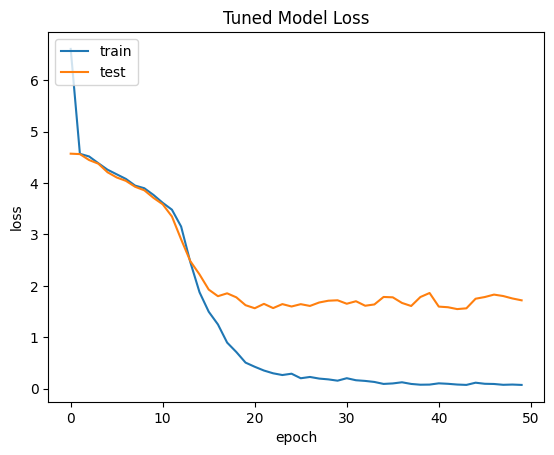

In [31]:
plt.plot(history_tuned.history['loss'])
plt.plot(history_tuned.history['val_loss'])
plt.title('Tuned Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

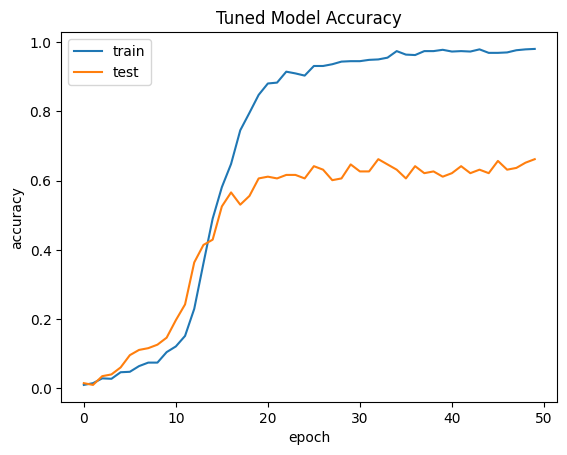

In [32]:
plt.plot(history_tuned.history['accuracy'])
plt.plot(history_tuned.history['val_accuracy'])
plt.title('Tuned Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Main (Untuned) model

### Build Model

This is the basic model before using Keras Tuner to tune hyperparameters.

In [21]:
img_data_shape = (image_size[0], image_size[1], 1)
csv_data_shape = (3, n_features)
num_classes = 99


# define two input layers
img_input = Input(shape=img_data_shape, name="image")
csv_input = Input(shape=csv_data_shape, name="csv")



# define 3 Conv2D layers for image data 
# x1 = Rescaling(1./255)(img_input) #DONE
x1 = Convolution2D(16, 3, padding='same', input_shape=(image_size[0], image_size[1], 1), activation='relu', name="conv1_img")(img_input)
x1 = MaxPooling2D(name="mxp1_img")(x1)
x1 = Dropout(0.25, name="dropout_images")(x1) #prevent overfittin
x1 = Convolution2D(32, 3, padding='same', activation='relu', name="conv2_img")(x1)
x1 = MaxPooling2D(name="mxp2_img")(x1)
x1 = Convolution2D(64, 3, padding='same', activation='relu', name="conv3_img")(x1)
x1 = MaxPooling2D(name="mxp3_img")(x1)
x1 = Flatten(name="flatten_img")(x1)

# define Conv1D and Dense layers for csv data
x2 = Convolution1D(512, 1, input_shape=(3, n_features), activation='relu')(csv_input)
x2 = Flatten(name="flatten_csv")(x2)
x2 = Dropout(0.25, name="dropout_csv")(x2) #prevent overfitting
x2 = Dense(16, activation='relu', name="dense1_csv")(x2)
x2 = Dense(32, activation='relu', name="dense2_csv")(x2)
x2 = Dense(64, activation='relu', name="dense3_csv")(x2)

# merge layers
x = concatenate([x1,x2], name="concat_csv_img")
x = Dense(n_classes * 2, activation='relu', name="dense1_csv_img")(x)
x = Dropout(0.5, name="dropout_merge")(x)
output = Dense(num_classes, activation='softmax', name="classify")(x)

# make model with 2 inputs and 1 output
model = Model(inputs=[img_input, csv_input], outputs=output)

# plot model
keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

In [22]:
optimizer = RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08, weight_decay=0.0)
    
model.compile(optimizer=optimizer,
            loss='categorical_crossentropy',
            metrics=['accuracy'])

print('Finished construction of the model')

Finished construction of the model


In [23]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image (InputLayer)          [(None, 180, 180, 1)]        0         []                            
                                                                                                  
 conv1_img (Conv2D)          (None, 180, 180, 16)         160       ['image[0][0]']               
                                                                                                  
 mxp1_img (MaxPooling2D)     (None, 90, 90, 16)           0         ['conv1_img[0][0]']           
                                                                                                  
 csv (InputLayer)            [(None, 3, 64)]              0         []                            
                                                                                            

In [24]:
batch_size = 32 #try 16
epochs = 15

#try early stopping
# early_stopping = EarlyStopping(monitor='val_loss', patience=300)

# history = model.fit(generator("training"), epochs=2, batch_size=batch_size, 
#                     steps_per_epoch=3, validation_data=generator("training"), validation_steps=1)
# autosave best Model
best_model_file = "leafnet.h5"
untuned_model = ModelCheckpoint(best_model_file, monitor='val_loss', verbose=1, save_best_only=True)

print('Training model...')
history = model.fit([X_images_train, X_tabular_train], y_train_cat,
                                # steps_per_epoch=X_tabular_train.shape[0],
                                epochs=epochs,
                                batch_size=batch_size,
                                validation_data=([X_images_valid, X_tabular_valid], y_valid_cat),
                                # validation_steps=X_tabular_valid.shape[0],
                                verbose=1,
                                callbacks=[untuned_model])

print('Loading the best model...')
model = load_model(best_model_file)
print('Best Model loaded!')

Training model...
Epoch 1/15


25/25 [==============================] - ETA: 0s - loss: 5.2018 - accuracy: 0.0189
Epoch 1: val_loss improved from inf to 4.47988, saving model to leafnet.h5


d:\My Applications\my_python_venvs\deep\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - 15s 430ms/step - loss: 5.2018 - accuracy: 0.0189 - val_loss: 4.4799 - val_accuracy: 0.0960
Epoch 2/15
25/25 [==============================] - ETA: 0s - loss: 4.0967 - accuracy: 0.1288
Epoch 2: val_loss improved from 4.47988 to 3.59669, saving model to leafnet.h5
25/25 [==============================] - 10s 391ms/step - loss: 4.0967 - accuracy: 0.1288 - val_loss: 3.5967 - val_accuracy: 0.3535
Epoch 3/15
25/25 [==============================] - ETA: 0s - loss: 3.1275 - accuracy: 0.2513
Epoch 3: val_loss improved from 3.59669 to 2.71175, saving model to leafnet.h5
25/25 [==============================] - 10s 407ms/step - loss: 3.1275 - accuracy: 0.2513 - val_loss: 2.7118 - val_accuracy: 0.4596
Epoch 4/15
25/25 [==============================] - ETA: 0s - loss: 2.2732 - accuracy: 0.4369
Epoch 4: val_loss improved from 2.71175 to 2.02547, saving model to leafnet.h5
25/25 [==============================] - 10s 410ms/step - loss: 2.2732 - accuracy: 0.

### Evaluate Untuned Model

In [25]:
print('val_acc: ',max(history.history['val_accuracy']))
print('val_loss: ',min(history.history['val_loss']))
print('train_acc: ',max(history.history['accuracy']))
print('train_loss: ',min(history.history['loss']))

print()
print("train/val loss ratio: ",min(history.history['loss'])/min(history.history['val_loss']))

val_acc:  0.7878788113594055
val_loss:  0.8624969124794006
train_acc:  0.9255050420761108
train_loss:  0.23614850640296936

train/val loss ratio:  0.2737963498606836


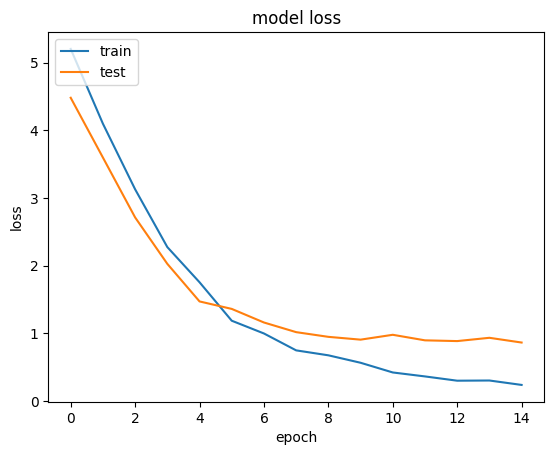

In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

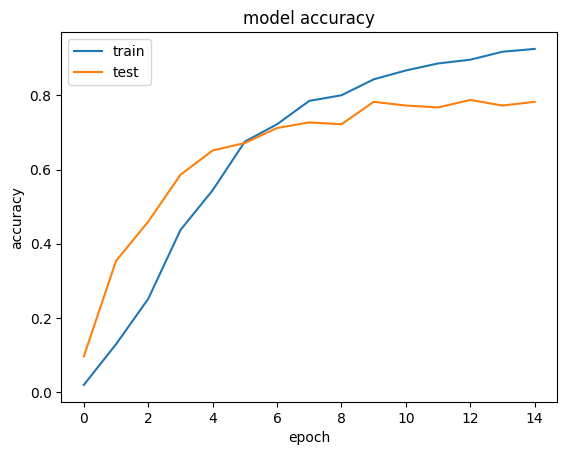

In [27]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [28]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch

C:\Users\YAS\AppData\Local\Temp\ipykernel_14556\3986964379.py:4: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [ ]:
#TODO 
# batch size
# no of layers in the model
# Dropout rate
# optimizer type
# weight_decay param in optimizer
# learning rate
# learning rate
# learning rate scheduler

# predict test dataset


# learning sources: 
# https://machinelearningmastery.com/tensorflow-tutorial-deep-learning-with-tf-keras/
# https://pyimagesearch.com/2018/12/31/keras-conv2d-and-convolutional-layers/
# https://www.tensorflow.org/tutorials/keras/keras_tuner#instantiate_the_tuner_and_perform_hypertuning
# model source:
# https://stackoverflow.com/questions/68793010/concatenate-image-and-csv-data-tensorflow
# kaggle notebook sources:
# https://www.kaggle.com/code/abhmul/keras-convnet-lb-0-0052-w-visualization#Combining-the-Image-CNN-with-the-Pre-Extracted-Features-MLP
# https://www.kaggle.com/code/ernie55ernie/keras-model-usage-on-leaf-classification/notebook#Train-and-test-split
# https://www.kaggle.com/code/tobikaggle/nn-through-keras-copied-mod-shuffle
# https://www.kaggle.com/code/shaikchinamoulali/leaf-classficatin-using-cnn/notebook



# sgd = SGD(lr=0.01, nesterov=True, decay=1e-6, momentum=0.9) 
# model.compile(loss='categorical_crossentropy',optimizer=sgd,metrics=['accuracy'])#try loss='sparse_categorical_crossentropy' #try 'rmsprop'

# #try early stopping
# # early_stopping = EarlyStopping(monitor='val_loss', patience=300)

# # history = model.fit(x_train, y_train,batch_size=192,epochs=2500 ,verbose=0,
# #                     validation_data=(x_val, y_val),callbacks=[early_stopping])
# model.fit(X_tabular_train, y_train_cat, epochs=epochs, validation_data=(X_images_valid, y_valid_cat), batch_size=batch_size)

In [ ]:

# https://machinelearningmastery.com/tensorflow-tutorial-deep-learning-with-tf-keras/ Here's what I learned.
# loss fn ‘sparse_categorical_crossentropy‘ for multi-class classification


# MLP
# An MLP is created with one or more Dense layers. This model is appropriate for tabular data, 
# that is data as it looks in a table or spreadsheet with one column for each variable and one row for each variable.



# MLP Classification
# Given that it is a multiclass classification, the model must have one node for each class in the output layer
# and use the softmax activation function. e.g. as in abhmul's kaggle notebook:
# # Get the final output
#     out = Dense(99, activation='softmax')(x)
#     # How we create models with the Functional API
#     model = Model(input=[image, numerical], output=out)
# The loss function is the ‘sparse_categorical_crossentropy‘, 
# which is appropriate for integer encoded class labels (e.g., 0 for one class, 1 for the next class, etc.)



# CNNs
# They are comprised of models with convolutional layers that extract features (called feature maps) 
# and pooling layers that distill features down to the most salient elements.
# CNNs are most well-suited to image classification tasks, although they can be used on a wide array 
# of tasks that take images as input.


#MNIST
# Note that the images are arrays of grayscale pixel data; therefore, we must add a channel dimension
#  to the data before we can use the images as input to the model. The reason is that CNN models expect images 
# in a channels-last format; that is, each example to the network has the dimensions [rows, columns, channels], 
# where channels represent the color channels of the image data.

# It is also a good idea to scale the pixel values from the default range of 0-255 to 0-1 when training a CNN. 
# For more on scaling pixel values, see the tutorial:
# How to Manually Scale Image Pixel Data for Deep Learning

# questions/ how do you determine the arguments passed to the layer? How do you determine which layers to use?
# what does kernel_initializer='he_normal' mean?
# model.add(Dense(n_features, activation='softmax')) #instead of n_features, the original article used 3. is this wrong?
#i'm not sure but, i think Flatten() must be after Conv() layers in the model.


## Predicting for test.csv

We can use either main or tuned model. Let us use tuned model aka 'final_model'

In [39]:
# Get the names of the column headers
LABELS = sorted(pd.read_csv('train.csv.zip').species.unique())


# Preprocess test data
test_IDs = test.pop('id')
test = StandardScaler().fit(test).transform(test) # standardize
test_reshaped = np.zeros((len(test), 3, n_features))
test_reshaped[:, 0, :] = test[:, :n_features]
test_reshaped[:, 1, :] = test[:, n_features:128]
test_reshaped[:, 2, :] = test[:, 128:]

# Fetch test images
test_images = [] 
for idx in test_IDs:
    image_path = os.path.join('images', str(idx)+ '.jpg')
    # img = Image.open(image_path)
    img = load_img(image_path, color_mode = "grayscale")
    img = img.resize(image_size) #resizing
    test_images.append(img)
# Displaying the first 25 images
# for i in range(25):
# 	plt.subplot(5, 5, i+1)
# 	plt.imshow(test_images[i], cmap=plt.get_cmap('gray'))
# plt.show()
# PIL Images array to Numpy array
test_images = np.asarray(test_images)
test_images = test_images.astype('float32')
test_images /= 255
 



# test_IDs, test, test_images # returns ID, numeric, and image
yPred_proba = final_model.predict([test_images, test_reshaped]) #[image input, tabular input] as described by model

# Converting the test predictions in a dataframe as depicted by sample submission
yPred = pd.DataFrame(yPred_proba, index=test_IDs, columns=LABELS)

print('Creating and writing submission...')
fp = open('salma_submit.csv', 'w')
fp.write(yPred.to_csv())
print('Finished writing submission')
# Display the submission
yPred.tail()

19/19 [==============================] - 7s 69ms/step
Creating and writing submission...
Finished writing submission


Acer_Capillipes  Acer_Circinatum     Acer_Mono   Acer_Opalus  \
id                                                                   
1576     2.237785e-05     8.315810e-01  3.035431e-03  2.644738e-04   
1577     4.186544e-09     4.412658e-08  6.892940e-11  1.067661e-03   
1579     5.845367e-06     8.145133e-09  3.821517e-06  2.910066e-04   
1580     2.278784e-07     1.487195e-10  1.149527e-08  2.046145e-08   
1583     5.222013e-12     6.578484e-11  5.556133e-12  1.321001e-09   

      Acer_Palmatum   Acer_Pictum  Acer_Platanoids   Acer_Rubrum  \
id                                                                 
1576   1.602777e-03  5.526901e-04     1.744401e-02  1.490331e-04   
1577   9.533767e-08  2.804416e-05     1.541143e-05  3.135695e-06   
1579   2.325938e-06  7.664442e-05     3.782437e-06  8.483464e-05   
1580   6.432829e-07  1.011687e-06     7.366565e-05  1.693854e-07   
1583   3.576288e-09  3.863551e-12     7.915878e-11  1.309492e-09   

      Acer_Rufinerve  Acer_Saccharinum  ...  Salix_Fragilis  Salix_Intergra  \
id                                      ...                                   
1576    1.002950e-01      2.764076e-03  ...    5.662334e-05    1.162954e-04   
1577    1.888924e-02      2.724038e-06  ...    4.967024e-11    2.873783e-07   
1579    7.645016e-05      5.902624e-06  ...    4.500589e-06    4.994363e-01   
1580    1.002409e-06      4.488415e-07  ...    4.197376e-08    1.152197e-07   
1583    1.343234e-12      1.779752e-10  ...    3.963004e-06    1.014026e-02   

       Sorbus_Aria  Tilia_Oliveri  Tilia_Platyphyllos  Tilia_Tomentosa  \
id                                                                       
1576  8.733624e-10   5.659173e-06        4.675820e-08     4.284310e-06   
1577  1.888500e-05   3.096959e-06        3.182173e-06     5.063307e-08   
1579  2.259229e-05   2.939450e-05        1.378429e-04     4.577110e-05   
1580  1.352605e-04   3.180109e-08        5.039124e-06     1.338202e-05   
1583  4.692509e-14   1.025130e-08        1.884860e-12     5.425467e-09   

      Ulmus_Bergmanniana  Viburnum_Tinus  Viburnum_x_Rhytidophylloides  \
id                                                                       
1576        3.058623e-07    5.806196e-04                  4.032893e-08   
1577        6.592244e-08    4.720798e-01                  1.011745e-07   
1579        1.101773e-05    1.331650e-05                  5.184192e-03   
1580        2.982264e-06    8.982693e-03                  3.066899e-05   
1583        7.604160e-12    2.972560e-12                  1.487723e-12   

      Zelkova_Serrata  
id                     
1576     2.366362e-05  
1577     1.307987e-07  
1579     9.917143e-07  
1580     1.128740e-07  
1583     3.828869e-11  

[5 rows x 99 columns]